In [1]:
import jax

jax.config.update("jax_enable_x64", True)
from torch.utils.data import DataLoader, Subset
import optax
import jax.numpy as jnp

from specq_jax.core import (
    SpecQDataset,
    create_train_step,
    loss as loss_fn,
    gate_loss,
    X,
    Y,
    Z,
    calculate_expvals,
    plot_expvals,
    gate_fidelity,
    Wo_2_level,
    calculate_exp,
    rotating_transmon_hamiltonian
)
from specq_jax.model import BasicBlackBox, ParallelBlackBox
from exp_data_0020 import get_exp_data
import specq_dev.specq.shared as specq

from jaxopt import ProjectedGradient
from jaxopt.projection import projection_box
import pandas as pd
import matplotlib.pyplot as plt
from alive_progress import alive_bar, alive_it

In [2]:
exp_data, pulse_parameters, unitaries, expectations, pulse_sequence, simulator = get_exp_data(rotating_transmon_hamiltonian)

Loaded data from 0020
Prepared the waveforms for the experiment 0020
Got the unitaries for the experiment 0020
Finished preparing the data for the experiment 0020


In [3]:
pauli_str = {
    "X": X,
    "Y": Y,
    "Z": Z,
}
eval_states = ["+", "r", "0", "1"]
eval_expvals = []

for state in eval_states:
    for gate in pauli_str:
        eval_expvals.append(specq.ExpectationValue(state, gate))

eval_expvals = specq.default_expectation_values

# Get the indices of expectation values to evaluate
eval_indices = []
for expval in eval_expvals:
    eval_indices.append(specq.default_expectation_values.index(expval))

eval_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [4]:
start_idx, end_idx = 0, 1500

# Final goal of setting up is to create a dataset and a dataloader
dataset = SpecQDataset(
    pulse_parameters=pulse_parameters[start_idx: end_idx],
    unitaries=unitaries[start_idx: end_idx],
    expectation_values=expectations[start_idx: end_idx, eval_indices],
)

batch_size = 150
# Randomly split dataset into training and validation
key = jax.random.PRNGKey(0)
val_indices = jax.random.choice(
    key, len(dataset), (int(0.2 * len(dataset)),), replace=False
).tolist()

training_indices = list(
    set([i for i in range(len(dataset))]) - set(val_indices)
)

train_dataset = Subset(dataset, training_indices)
val_dataset = Subset(dataset, val_indices)

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

len(train_dataloader), len(val_dataloader)

(8, 2)

In [5]:
key, model_key = jax.random.split(jax.random.PRNGKey(0))
model = BasicBlackBox(feature_size=5)
# model = ParallelBlackBox(hidden_sizes=(20, 10))
# optimiser = optax.adam(learning_rate=1e-3)

warmup_start_lr, warmup_steps = 1e-6, 1000
start_lr, end_lr, steps = 1e-2, 1e-6, 10_000
lr_scheduler = optax.join_schedules(
    [
        optax.linear_schedule(
            warmup_start_lr,
            start_lr,
            warmup_steps,
        ),
        optax.linear_schedule(
            start_lr,
            end_lr,
            steps - warmup_steps,
        ),
    ],
    [warmup_steps],
)

optimiser = optax.adam(lr_scheduler)

train_step, test_step, model_params, opt_state = create_train_step(
    key=model_key,
    model=model,
    optimiser=optimiser,
    loss_fn=lambda params, pulse_parameters, unitaries, expectations: loss_fn(
        params, pulse_parameters, unitaries, expectations, model, eval_expvals
    ),
    input_shape=(batch_size, pulse_parameters.shape[1]),
)

In [18]:
def standard_train(
    dataloader: DataLoader,
    train_step,
    model_params,
    opt_state,
):
    history = []
    total_len = len(dataloader)

    NUM_EPOCHS = 1250

    with alive_bar( int(NUM_EPOCHS*total_len)) as bar:
        for epoch in range(NUM_EPOCHS):
            total_loss = 0.0
            for i, batch in enumerate(dataloader):

                _pulse_parameters = batch["x0"].numpy()
                _unitaries = batch["x1"].numpy()
                _expectations = batch["y"].numpy()

                model_params, opt_state, loss = train_step(
                    model_params, opt_state, _pulse_parameters, _unitaries, _expectations
                )

                history.append(
                    {
                        "epoch": epoch,
                        "step": i,
                        "loss": float(loss),
                        "global_step": epoch * total_len + i,
                    }
                )

                total_loss += loss

                bar()

    return model_params, opt_state, history

# model_params, opt_state, history = standard_train(
#     train_dataloader,
#     train_step,
#     model_params,
#     opt_state,
# )

In [6]:
def with_validation_train(
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    train_step,
    test_step,
    model_params,
    opt_state,
    num_epochs=1250,
):

    history = []
    total_len = len(train_dataloader)

    NUM_EPOCHS = num_epochs

    with alive_bar(int(NUM_EPOCHS * total_len), force_tty=True) as bar:
        for epoch in range(NUM_EPOCHS):
            total_loss = 0.0
            for i, batch in enumerate(train_dataloader):

                _pulse_parameters = batch["x0"].numpy()
                _unitaries = batch["x1"].numpy()
                _expectations = batch["y"].numpy()

                model_params, opt_state, loss = train_step(
                    model_params, opt_state, _pulse_parameters, _unitaries, _expectations
                )

                history.append(
                    {
                        "epoch": epoch,
                        "step": i,
                        "loss": float(loss),
                        "global_step": epoch * total_len + i,
                        "val_loss": None,
                    }
                )

                total_loss += loss

                bar()

            # Validation
            val_loss = 0.0
            for i, batch in enumerate(val_dataloader):

                _pulse_parameters = batch["x0"].numpy()
                _unitaries = batch["x1"].numpy()
                _expectations = batch["y"].numpy()

                val_loss += test_step(model_params, _pulse_parameters, _unitaries, _expectations)

            history[-1]["val_loss"] = float(val_loss / len(val_dataloader))


    return model_params, opt_state, history

model_params, opt_state, history = with_validation_train(
    train_dataloader,
    val_dataloader,
    train_step,
    test_step,
    model_params,
    opt_state,
)

|                                        | ▁▃▅ 0/10000 [0%] in 0s (~0s, 0.0/s) 

on 0: /Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
        x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


|████████████████████████████████████████| 10000/10000 [100%] in 29.5s (339.82/s


(<Figure size 1000x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

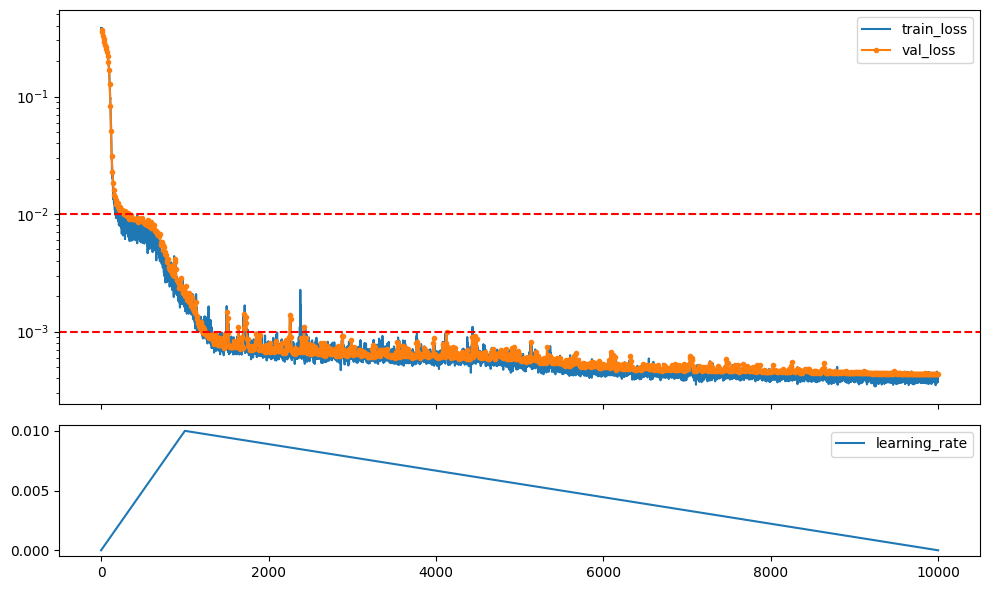

In [7]:
def plot_history(history, lr_scheduler):

    hist_df = pd.DataFrame(history)
    train = hist_df[["global_step", "loss"]].values

    train_x = train[:, 0]
    train_y = train[:, 1]

    validate = hist_df[["global_step", "val_loss"]].replace(0, jnp.nan).dropna().values

    validate_x = validate[:, 0]
    validate_y = validate[:, 1]
    # The second plot has height ratio 2
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, height_ratios=[3,1])

    # The first plot is the training loss and the validation loss
    ax[0].plot(train_x, train_y, label="train_loss")
    ax[0].plot(validate_x, validate_y, '.-', label="val_loss")
    ax[0].set_yscale("log")

    # plot the horizontal line [1e-3, 1e-2]
    ax[0].axhline(1e-3, color="red", linestyle="--")
    ax[0].axhline(1e-2, color="red", linestyle="--")

    # The second plot is the learning rate
    lr = lr_scheduler(train_x)
    ax[1].plot(train_x, lr, label="learning_rate")
    # ax[1].set_yscale("log")

    # for thred in [1e-3, 1e-2, 1e-5, 1e-4]:
    #     ax[1].axhline(thred, color="red", linestyle="--")

    ax[0].legend()
    ax[1].legend()

    fig.tight_layout()

    return fig, ax

plot_history(history, lr_scheduler)

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


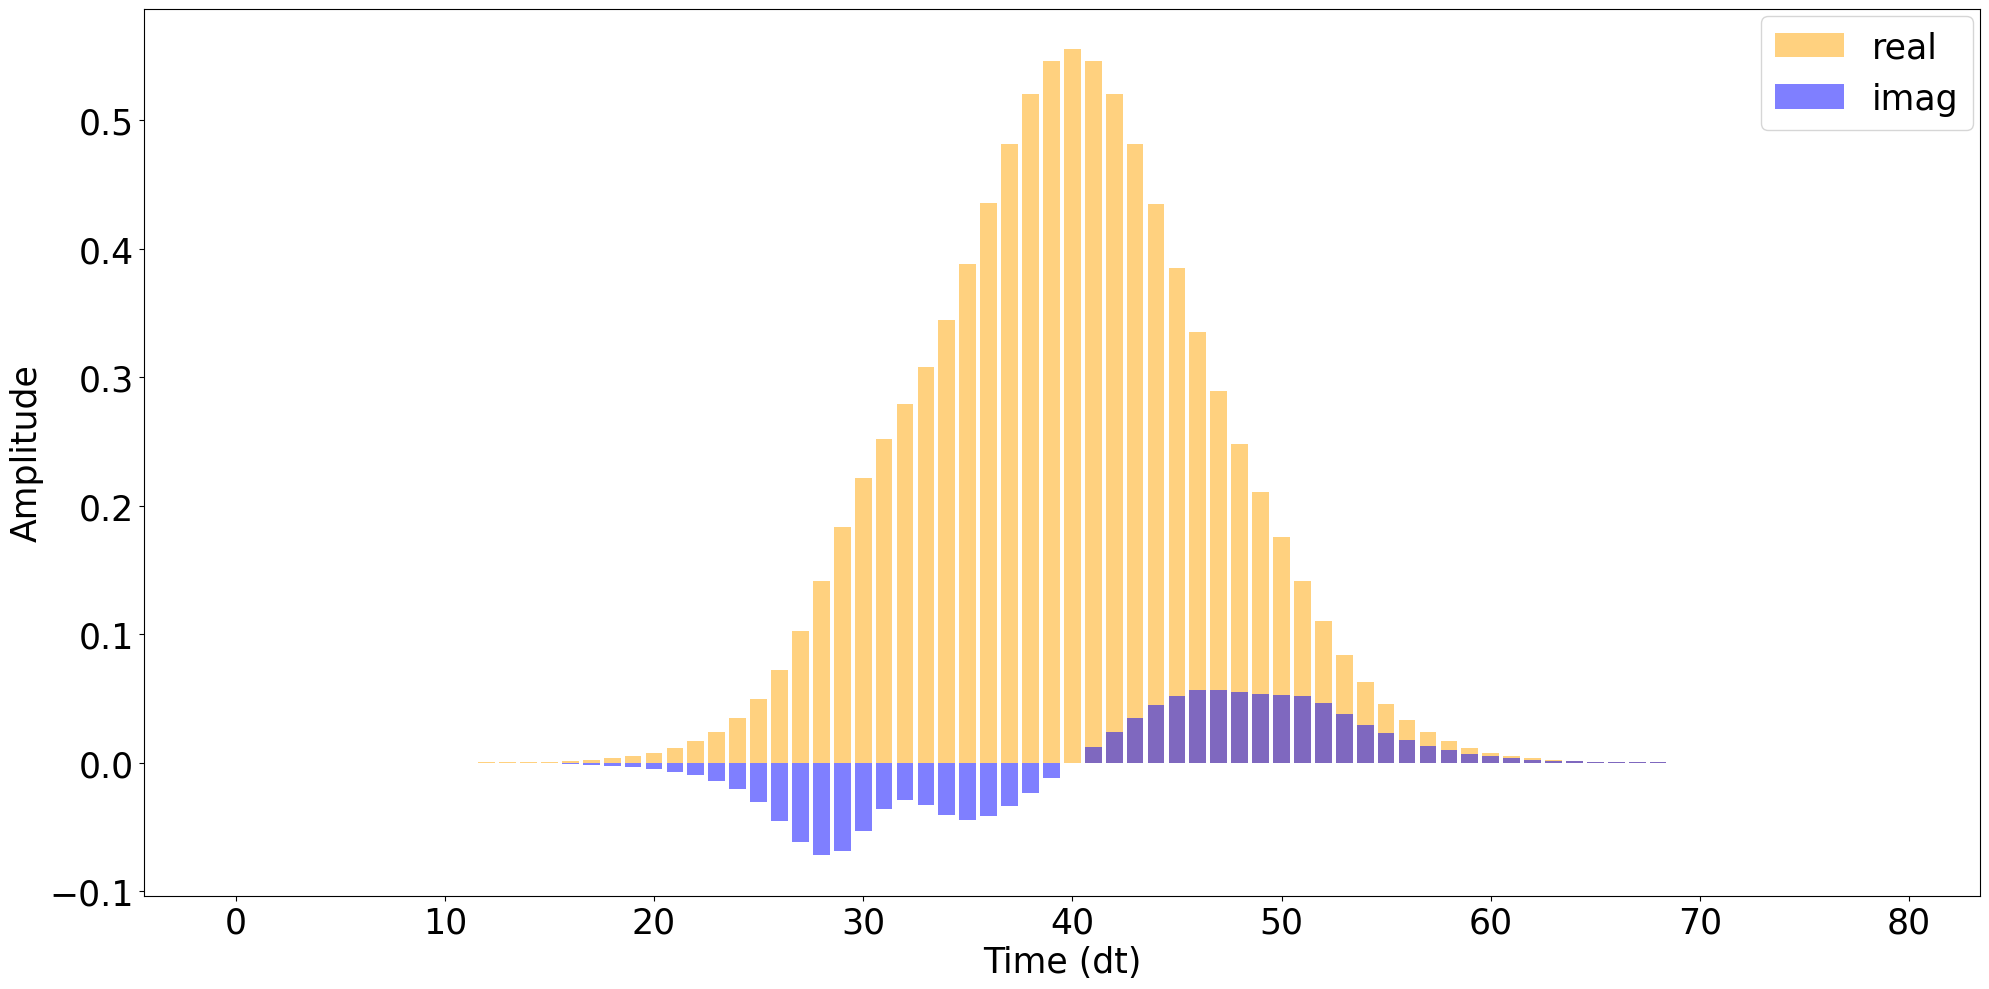

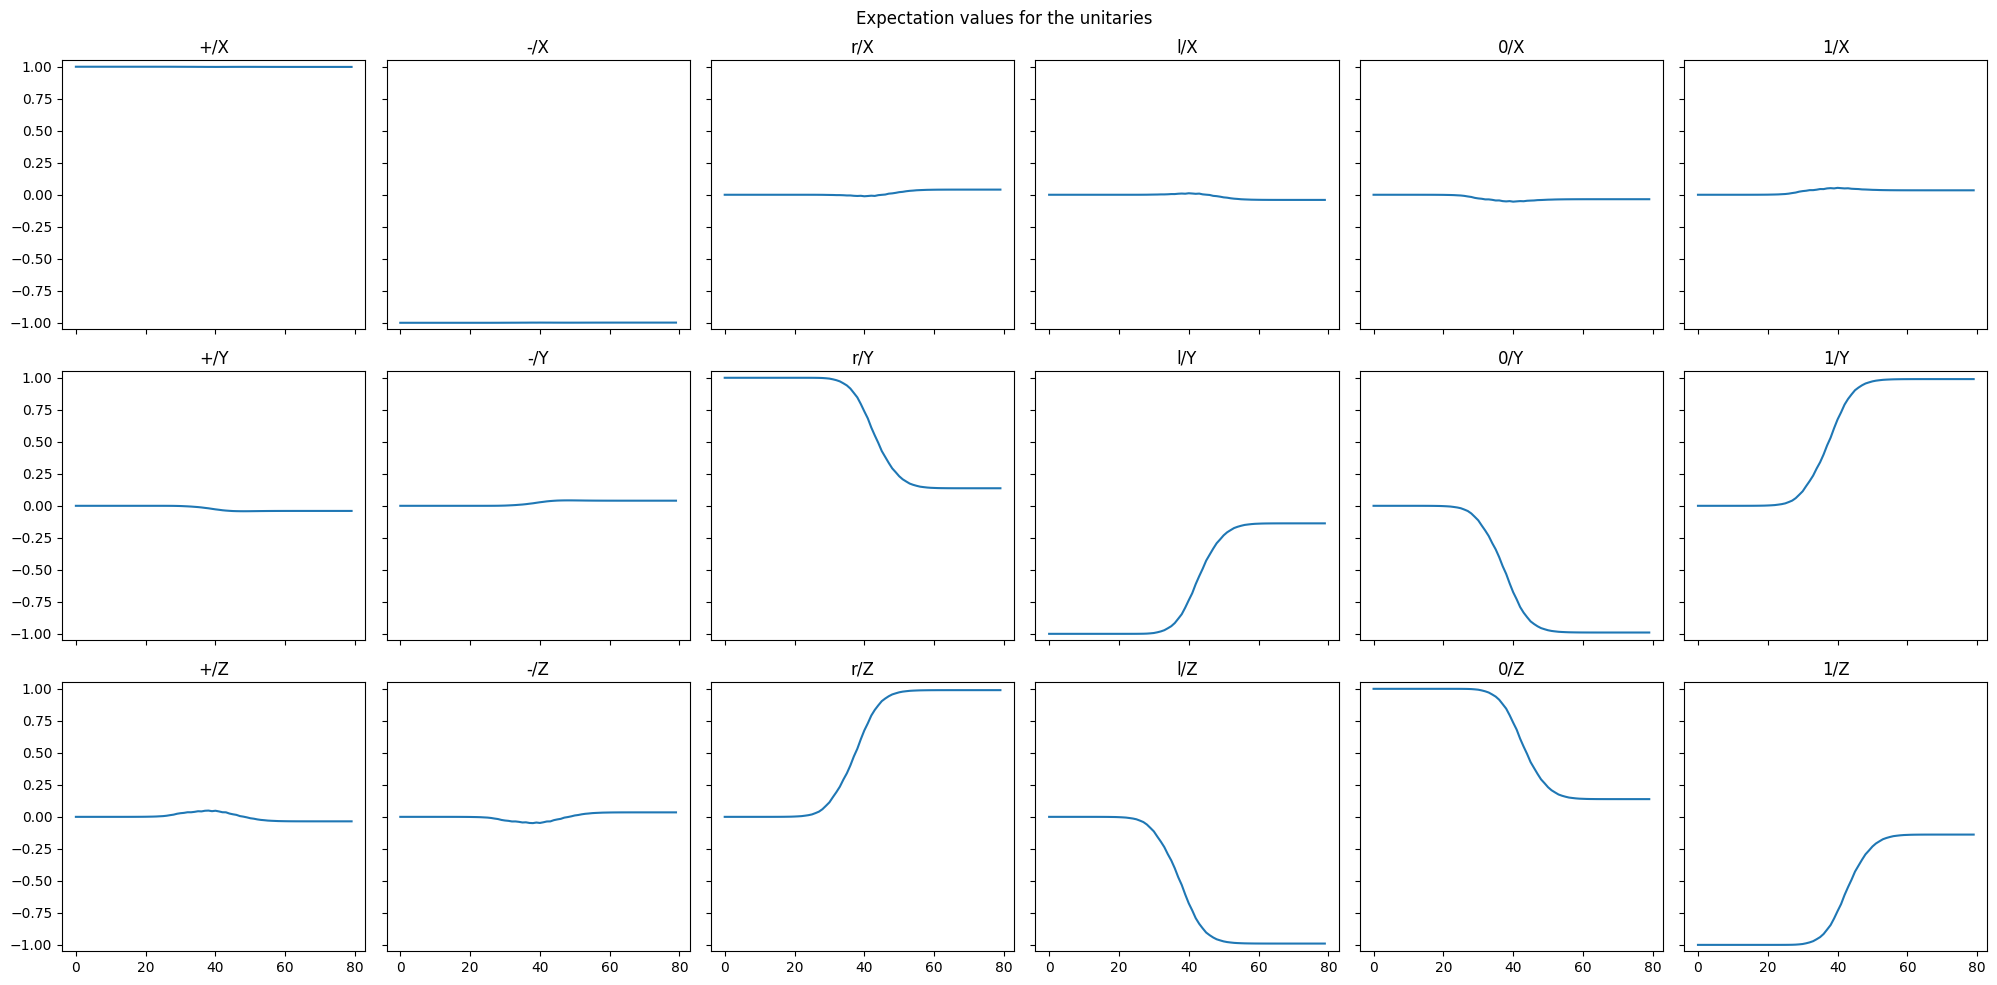

In [8]:
target_unitary = jax.scipy.linalg.sqrtm(X)
fun = lambda x: gate_loss(x, model, model_params, simulator, pulse_sequence, target_unitary)

bounds = []
sigma_range = [(7, 9), (5, 7), (3, 5), (1, 3)]
for i in range(1, 5):
    for j in range(i):
        bounds.append((0, 0.95)) # Amp
        bounds.append((-2, 2)) # Beta
        bounds.append(sigma_range[i-1]) # Sigma

lower = jnp.array([b[0] for b in bounds])
upper = jnp.array([b[1] for b in bounds])

key = jax.random.PRNGKey(0)
pulse_params = pulse_sequence.sample_params(key)
x0 = pulse_sequence.list_of_params_to_array(pulse_params)

pg = ProjectedGradient(fun=fun, projection=projection_box)
opt_params_2, state = pg.run(
    jnp.array(x0),
    hyperparams_proj=(lower, upper)
)

# Plot the optmized result
opt_pulse_params = pulse_sequence.array_to_list_of_params(opt_params_2)
pulse_sequence.draw(opt_pulse_params)

# Calculate the expectation values
waveforms = pulse_sequence.get_waveform(opt_pulse_params)
unitaries_opt = simulator(waveforms)

expvals = calculate_expvals(unitaries_opt)
plot_expvals(expvals)

In [10]:
Wo_params = model.apply(model_params, jnp.expand_dims(opt_params_2, axis=0))
Wo_params = jax.tree_map(lambda x: jnp.squeeze(x, 0), Wo_params)

fidelities = {}
for pauli_str, pauli_op in zip(["X", "Y", "Z"], [X, Y, Z]):
    Wo = Wo_2_level(U=Wo_params[pauli_str]["U"], D=Wo_params[pauli_str]["D"])
    # evaluate the fidleity to the Pauli operator
    fidelities[pauli_str] = gate_fidelity(Wo, pauli_op)

fidelities, gate_fidelity(unitaries_opt[-1], target_unitary)

/var/folders/rm/_5r9_x2s3tgfyqlnv1pdjfqc0000gn/T/ipykernel_98977/1722958540.py:2: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  Wo_params = jax.tree_map(lambda x: jnp.squeeze(x, 0), Wo_params)


({'X': Array(0.98808053, dtype=float64),
  'Y': Array(0.99458179, dtype=float64),
  'Z': Array(0.99404312, dtype=float64)},
 Array(0.99452063, dtype=float64))

## Performance analysis

### Dataset analysis

|████████████████████████████████████████| 1500/1500 [100%] in 53.6s (28.02/s)   ▄▆█ 920/1500 [61%] in 32s (~21s, 28.4


'<!DOCTYPE html>\n\n<html>\n<head>\n<meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>\n<title>HiPlot</title>\n<link href="" rel="icon"/>\n</head>\n<body style="margin:0px">\n<div id="hiplot_94a463c336344223a873cb3d13e680e4" style="background-color: white"><div style="text-align: center">Loading HiPlot...</div>\n<noscript>\n        HiPlot needs JavaScript to run\n      </noscript>\n</div>\n<script type="text/javascript">/*! For license information please see hiplot.bundle.js.LICENSE.txt */\nvar hiplot;(function(){var __webpack_modules__={1936:function(t,e,n){"use strict";var r=n(3601),i=n.n(r),o=n(3495),a=n.n(o)()(i());a.push([t.id,".hip_thm--dark{/*!\\n * Bootstrap v4.6.0 (https://getbootstrap.com/)\\n * Copyright 2011-2021 The Bootstrap Authors\\n * Copyright 2011-2021 Twitter, Inc.\\n * Licensed under MIT (https://github.com/twbs/bootstrap/blob/main/LICENSE)\\n */@import\\"https://fonts.googleapis.com/css?family=Lato:400,700,400italic&display=swap\\"}.hip_thm--dark 
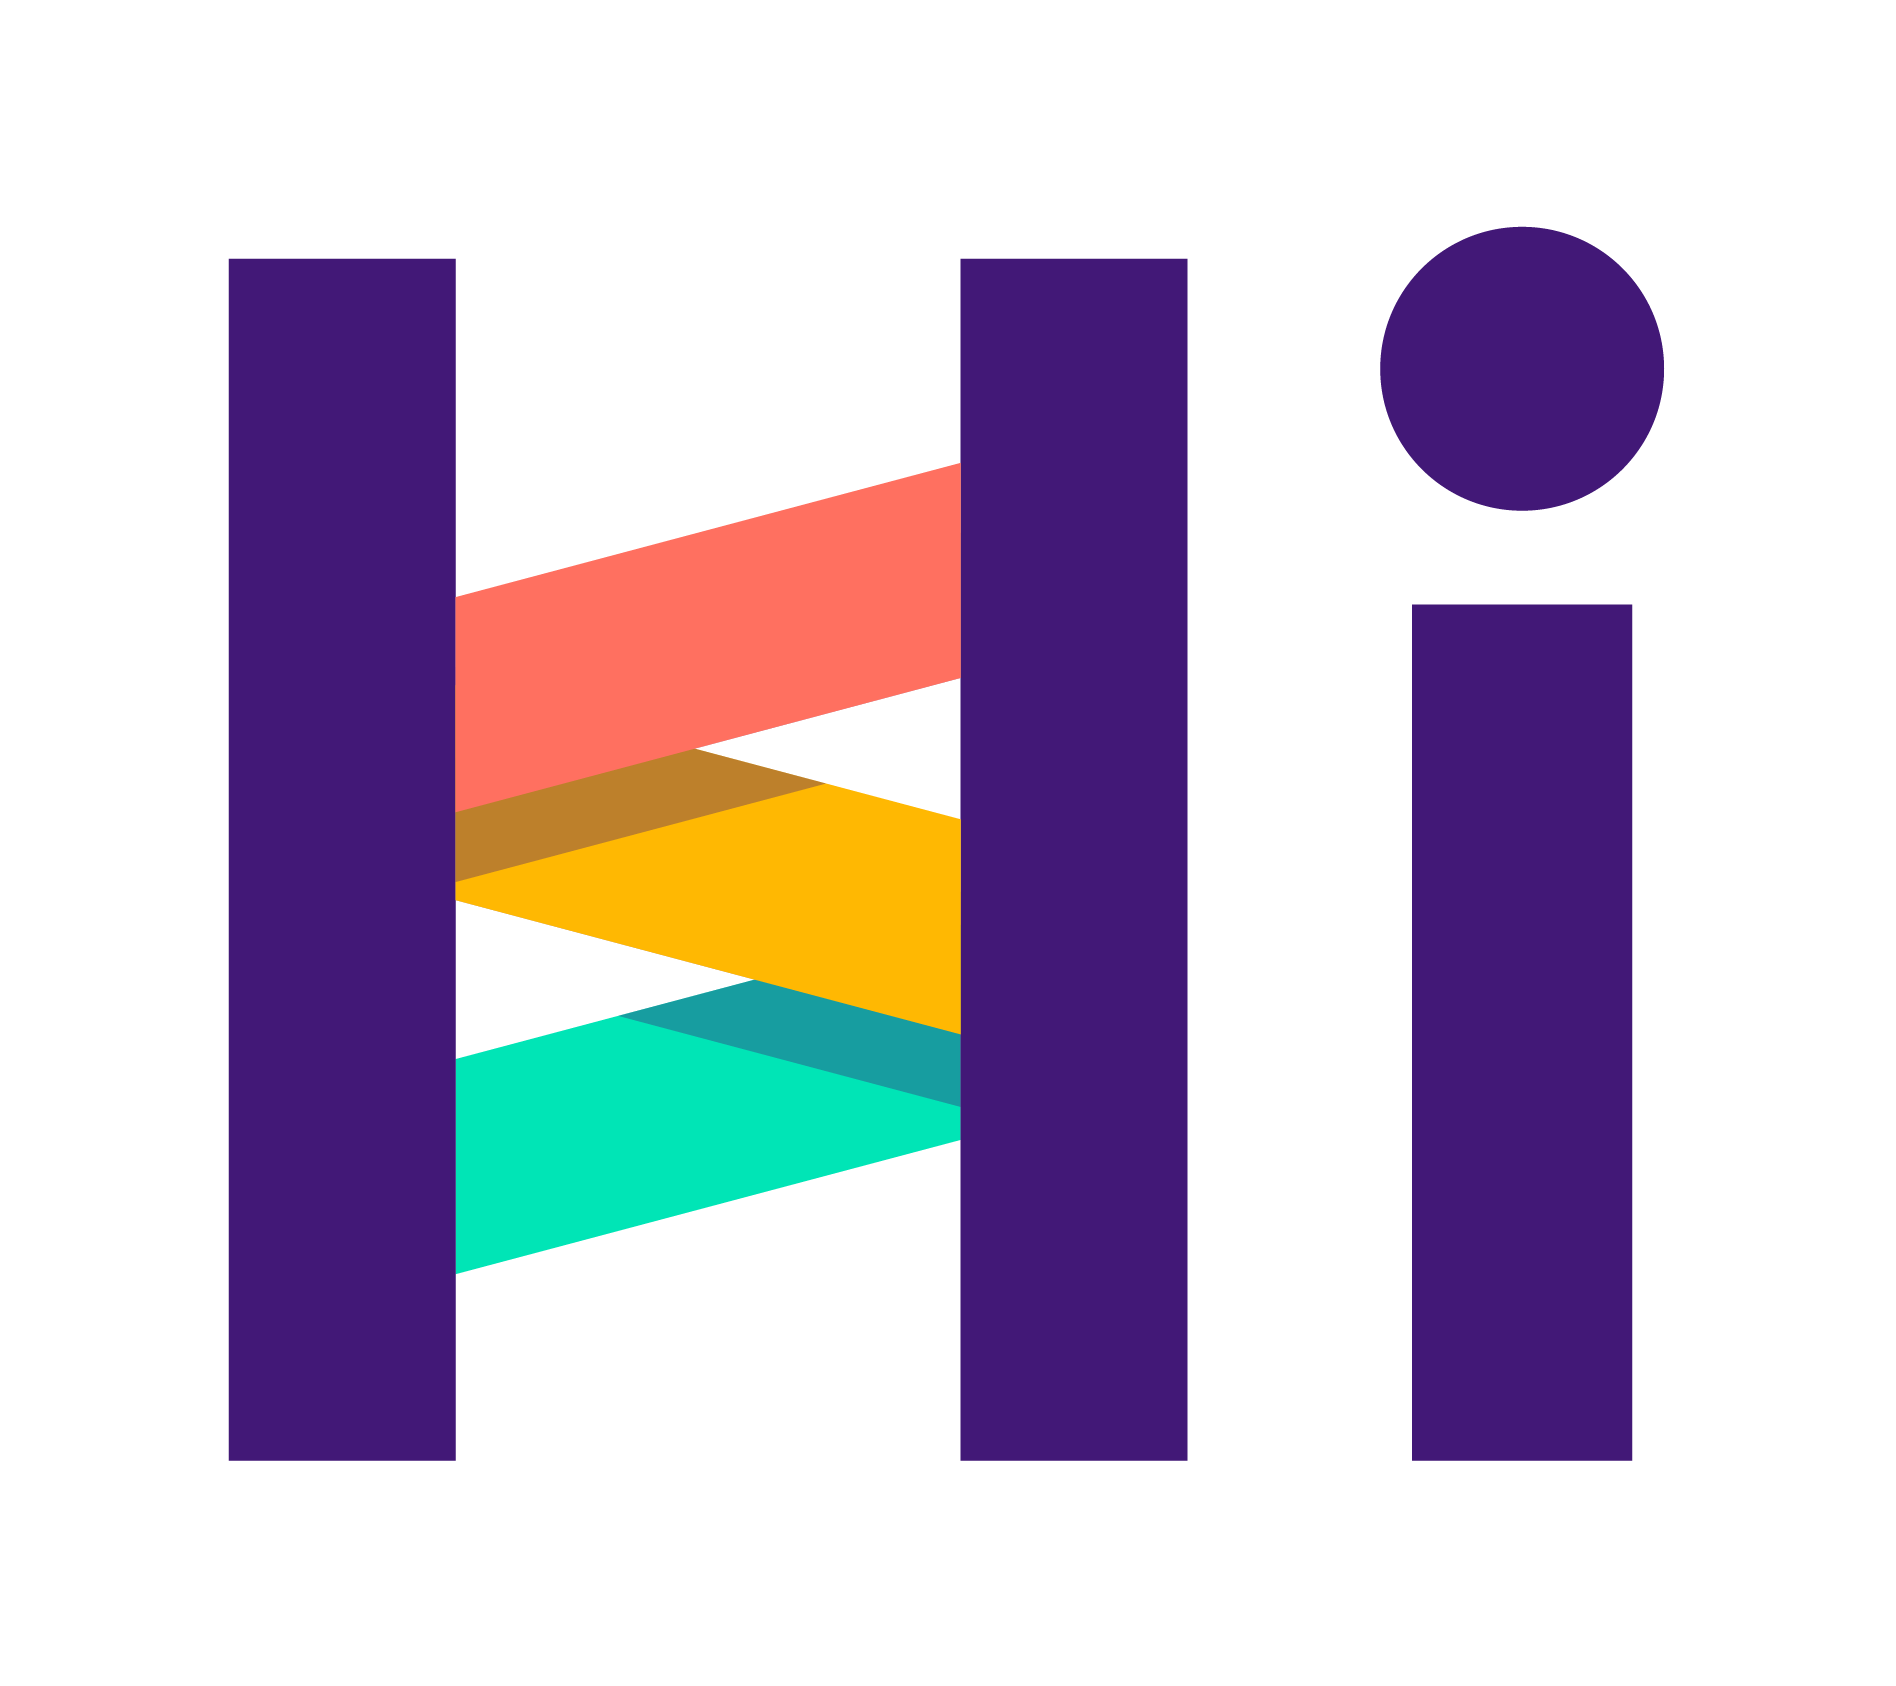

In [53]:
import hiplot as hip

key = jax.random.PRNGKey(0)
ds = dataset
random_indices = jax.random.randint(key, (5,), 0, len(ds))
random_indices = range(0, len(ds))

random_entries = []
for i in alive_it(random_indices, force_tty=True):
    Wo_params = model.apply(
        model_params, jnp.expand_dims(jnp.array(ds[i]["x0"]), axis=0)
    )
    Wo_params = jax.tree_map(lambda x: jnp.squeeze(x, 0), Wo_params)

    fidelities = {}
    for pauli_str, pauli_op in zip(["X", "Y", "Z"], [X, Y, Z]):
        Wo = Wo_2_level(U=Wo_params[pauli_str]["U"], D=Wo_params[pauli_str]["D"])
        # evaluate the fidleity to the Pauli operator
        fidelities[pauli_str] = float(gate_fidelity(Wo, pauli_op))

    # Compute the fidelity to target unitary
    fidelities["gate fidelity"] = float(gate_fidelity(jnp.array(ds[i]["x1"]), target_unitary))

    random_entries.append(
        {
            **fidelities,
        }
    )

df = pd.DataFrame(random_entries)
hip.Experiment.from_dataframe(df).to_html("exp_0020_hiplot.html")

In [54]:
# Get the list of dict from the dataframe
data = exp_data.postprocessed_data.to_dict(orient="records")

In [55]:
def analytic_Wo(expvals: dict, unitary: jnp.ndarray):

    exp_obs_0 = expvals["0"]
    exp_obs_1 = expvals["1"]
    exp_obs_plus = expvals["+"]
    exp_obs_r = expvals["r"]

    w_00 = exp_obs_0
    w_11 = exp_obs_1
    w_01 = 0.5 * ( (2 * exp_obs_plus - exp_obs_0 - exp_obs_1) +  1j* (exp_obs_0 + exp_obs_1 - 2 * exp_obs_r) )
    w_10 = jnp.conj(w_01)

    W_prime = jnp.array([[w_00, w_01], [w_10, w_11]])
    Wo = unitary @ W_prime @ jnp.conj(unitary).T

    return Wo

In [56]:
Wo_predicted = {}
# Predict all Wo using the model
Wo_params = model.apply(model_params, jnp.array(pulse_parameters))
for pauli_str in ["X", "Y", "Z"]:
    # For each Pauli operator, predict the Wo corresponding to the pauli and pulse parameters
    batched_Wo = jax.vmap(Wo_2_level, in_axes=(0, 0))(Wo_params[pauli_str]["U"], Wo_params[pauli_str]["D"])
    Wo_predicted[pauli_str] = batched_Wo

In [57]:
rows = []
for index in alive_it(range(0, len(data)), force_tty=True):
    expectation_values = {}
    row = data[index]

    for exp in specq.default_expectation_values:
        Wo_analytic = analytic_Wo(
            {
                "0": row[f"expectation_value/0/{exp.observable}"],
                "1": row[f"expectation_value/1/{exp.observable}"],
                "+": row[f"expectation_value/+/{exp.observable}"],
                "r": row[f"expectation_value/r/{exp.observable}"],
            },
            unitaries[index],
        )
        analytic_exp = calculate_exp(
            unitaries[index],
            Wo_analytic,
            initial_state=jnp.array(exp.initial_statevector),
        )

        predicted_exp = calculate_exp(
            unitaries[index],
            Wo_predicted[exp.observable][index],
            initial_state=jnp.array(exp.initial_statevector),
        )

        PREFIX = f"exp/{exp.initial_state}/{exp.observable}"

        # Store each with prefix
        expectation_values[f"{PREFIX}/analytic"] = float(analytic_exp)
        expectation_values[f"{PREFIX}/predicted"] = float(predicted_exp)
        expectation_values[f"{PREFIX}/experiment"] = row[
            f"expectation_value/{exp.initial_state}/{exp.observable}"
        ]

    rows.append(expectation_values)

|████████████████████████████████████████| 1500/1500 [100%] in 21.4s (70.04/s)  


In [58]:
df = pd.DataFrame(rows)

diff_e_a = []
diff_e_p = []
for exp in specq.default_expectation_values:
    base_col_name = f"exp/{exp.initial_state}/{exp.observable}"
    
    experiment_cols = df[f"{base_col_name}/experiment"]

    e_p = f"{base_col_name}/e-p"
    # New column for the difference between the predicted and the experiment
    df[e_p] = experiment_cols - df[f"{base_col_name}/predicted"]

    diff_e_p.append(e_p)
    
    e_a = f"{base_col_name}/e-a"
    # New column for the difference between the analytic and the experiment
    df[e_a] = experiment_cols - df[f"{base_col_name}/analytic"]

    diff_e_a.append(e_a)

array([[<Axes: title={'center': 'exp/+/X/e-a'}>,
        <Axes: title={'center': 'exp/-/X/e-a'}>,
        <Axes: title={'center': 'exp/r/X/e-a'}>,
        <Axes: title={'center': 'exp/l/X/e-a'}>],
       [<Axes: title={'center': 'exp/0/X/e-a'}>,
        <Axes: title={'center': 'exp/1/X/e-a'}>,
        <Axes: title={'center': 'exp/+/Y/e-a'}>,
        <Axes: title={'center': 'exp/-/Y/e-a'}>],
       [<Axes: title={'center': 'exp/r/Y/e-a'}>,
        <Axes: title={'center': 'exp/l/Y/e-a'}>,
        <Axes: title={'center': 'exp/0/Y/e-a'}>,
        <Axes: title={'center': 'exp/1/Y/e-a'}>],
       [<Axes: title={'center': 'exp/+/Z/e-a'}>,
        <Axes: title={'center': 'exp/-/Z/e-a'}>,
        <Axes: title={'center': 'exp/r/Z/e-a'}>,
        <Axes: title={'center': 'exp/l/Z/e-a'}>],
       [<Axes: title={'center': 'exp/0/Z/e-a'}>,
        <Axes: title={'center': 'exp/1/Z/e-a'}>, <Axes: >, <Axes: >]],
      dtype=object)

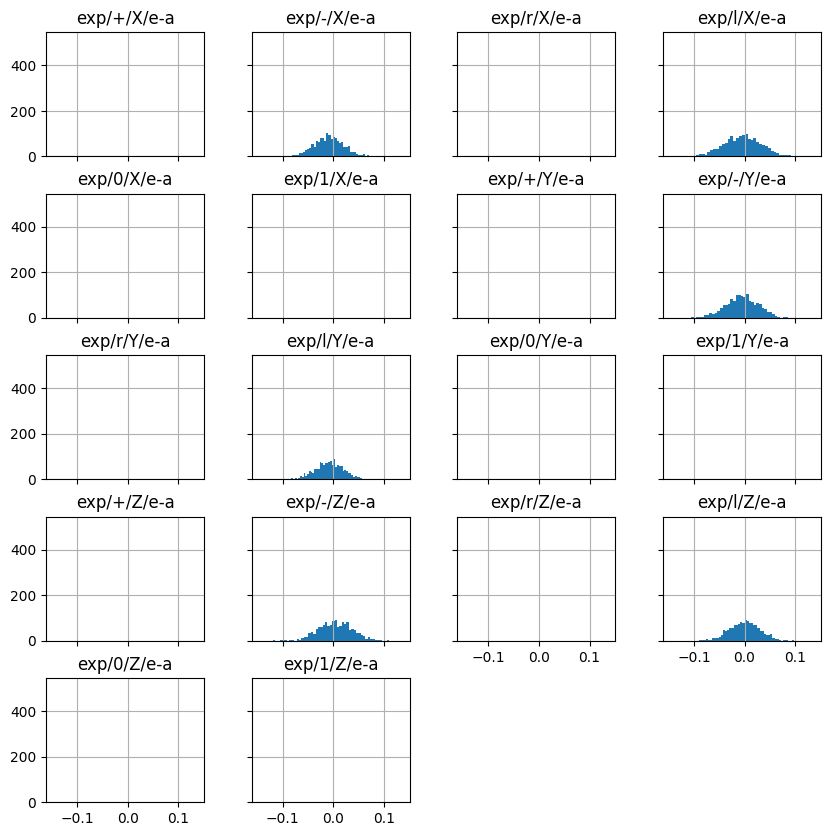

In [59]:
df[diff_e_a].hist(bins=50, figsize=(10, 10), sharex=True, sharey=True)

array([[<Axes: title={'center': 'exp/+/X/e-p'}>,
        <Axes: title={'center': 'exp/-/X/e-p'}>,
        <Axes: title={'center': 'exp/r/X/e-p'}>,
        <Axes: title={'center': 'exp/l/X/e-p'}>],
       [<Axes: title={'center': 'exp/0/X/e-p'}>,
        <Axes: title={'center': 'exp/1/X/e-p'}>,
        <Axes: title={'center': 'exp/+/Y/e-p'}>,
        <Axes: title={'center': 'exp/-/Y/e-p'}>],
       [<Axes: title={'center': 'exp/r/Y/e-p'}>,
        <Axes: title={'center': 'exp/l/Y/e-p'}>,
        <Axes: title={'center': 'exp/0/Y/e-p'}>,
        <Axes: title={'center': 'exp/1/Y/e-p'}>],
       [<Axes: title={'center': 'exp/+/Z/e-p'}>,
        <Axes: title={'center': 'exp/-/Z/e-p'}>,
        <Axes: title={'center': 'exp/r/Z/e-p'}>,
        <Axes: title={'center': 'exp/l/Z/e-p'}>],
       [<Axes: title={'center': 'exp/0/Z/e-p'}>,
        <Axes: title={'center': 'exp/1/Z/e-p'}>, <Axes: >, <Axes: >]],
      dtype=object)

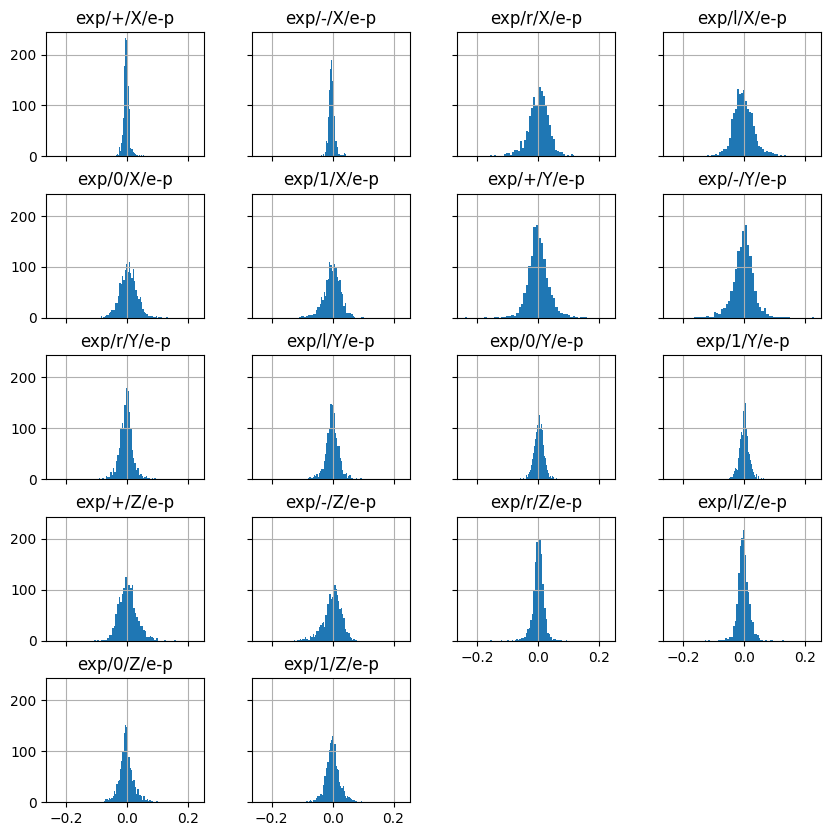

In [60]:
df[diff_e_p].hist(bins=50, figsize=(10, 10), sharex=True, sharey=True)

In [1]:
from specq_jax.pulse import MultiDragPulse, JaxBasedPulseSequence

In [3]:
JaxBasedPulseSequence.from_file("../../specq-experiment/datasets/0020", pulses=[MultiDragPulse] * 4)

JaxBasedPulseSequence(pulses=[MultiDragPulse(total_length=80, num_drag=1, min_amp=0, max_amp=0.95, min_sigma=7, max_sigma=9, min_beta=-2, max_beta=2), MultiDragPulse(total_length=80, num_drag=2, min_amp=0, max_amp=0.95, min_sigma=5, max_sigma=7, min_beta=-2, max_beta=2), MultiDragPulse(total_length=80, num_drag=3, min_amp=0, max_amp=0.95, min_sigma=3, max_sigma=5, min_beta=-2, max_beta=2), MultiDragPulse(total_length=80, num_drag=4, min_amp=0, max_amp=0.95, min_sigma=1, max_sigma=3, min_beta=-2, max_beta=2)], pulse_length_dt=80)